# import package

In [3]:
# 資料處理
import pandas as pd
import numpy as np
# 進度條
from tqdm import tqdm
# 資料分割
from sklearn.model_selection import train_test_split
# 類別向量轉為二進制矩陣
# from keras.utils import to_categorical
# 讀取模型
# from keras.models import load_model
# 載入圖片
from keras.preprocessing import image
# 檢視圖片
from matplotlib import pyplot as plt

# 建立模型
import tensorflow as tf
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers import Conv2D, MaxPool2D
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.utils import plot_model
# 編譯模型
from keras import optimizers
# 訓練模型
import time
import os
from keras.callbacks import ModelCheckpoint, EarlyStopping

# 圖片

## 定義讀取圖片

In [4]:
def load_image(file_name, dataset_name, dataset_path, input_size, array_name):
    data = pd.read_csv(file_name)
    dataset_name = []
    for i in tqdm(range(data.shape[0])):
        # target_size為載入圖片後將大小縮放至設定的大小
        img = image.load_img(dataset_path + data["File_name"][i], 
                             target_size = input_size)
        img = image.img_to_array(img)
        img = img/255 # 圖像歸一化(x-0/255-0)
        dataset_name.append(img)
    array_name = np.array(dataset_name)
    return array_name

## 執行讀取圖片

In [5]:
train_image = load_image("D:/10979104/碩論程式整理/data_csv/train_image.csv"
                         , "train_image"
                         , "D:/10979104/碩論程式整理/train_data/"
                         , (299,299,1)
                         , "X_train")

valid_image = load_image("D:/10979104/碩論程式整理/data_csv/valid_image.csv"
                         , "valid_image"
                         , "D:/10979104/碩論程式整理/valid_data/"
                         , (299,299,1)
                         , "X_valid")

test_image = load_image("D:/10979104/碩論程式整理/data_csv/test_image.csv"
                         , "test_image"
                         , "D:/10979104/碩論程式整理/test_data/"
                         , (299,299,1)
                         , "X_test")

100%|█████████████████████████████████████████████████████████████████████████████| 1040/1040 [00:08<00:00, 124.12it/s]


## 檢視圖片

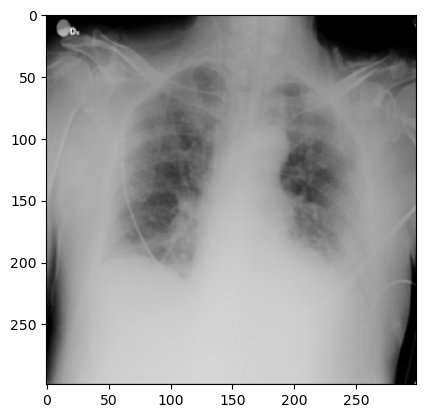

In [6]:
plt.imshow(train_image[0])
plt.show()

## 設定圖片標籤

In [7]:
train_label = pd.read_csv("D:/10979104/碩論程式整理/data_csv/train_label.csv")
valid_label = pd.read_csv("D:/10979104/碩論程式整理/data_csv/valid_label.csv")
test_label = pd.read_csv("D:/10979104/碩論程式整理/data_csv/test_label.csv")

# 建立模型

## 定義模型

In [8]:
def CNN(input_size):
    model = Sequential()
    # 第一組
    model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=input_size))
    #model.add(Dropout(0.25))
    model.add((MaxPool2D(pool_size=(2, 2))))
    # 第二組
    model.add(Conv2D(filters=32, kernel_size=(5, 5), activation="relu"))
    #model.add(Dropout(0.25))
    model.add(MaxPool2D(pool_size=(2, 2)))
    # 第三組
    model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
    model.add(Dropout(0.25))
    model.add(MaxPool2D(pool_size=(2, 2)))
    # 第四組
    model.add(Conv2D(filters=128, kernel_size=(5, 5), activation="relu"))
    model.add(Dropout(0.25))
    model.add(MaxPool2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(4, kernel_regularizer=tf.keras.regularizers.l2(0.01), activation="softmax"))
    return model

## 執行建立

In [9]:
input_size = (299,299,3)
model = CNN(input_size) 

### 模型總結

In [10]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 295, 295, 16)      1216      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 147, 147, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 143, 143, 32)      12832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 71, 71, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 67, 67, 64)        51264     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 33, 33, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 29, 29, 128)      

## 編譯模型

In [12]:
adam = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=adam, 
              loss='squared_hinge', 
              metrics=["accuracy"])

## 訓練模型-停止條件、紀錄權重

In [16]:
earlystopping = EarlyStopping(monitor = "val_loss", 
                patience = 40, 
                verbose = 1, # 0:不通知 1:通知
                mode = "min", 
                min_delta = 0.003) # 最小變化符合改進的條件

checkpoint = ModelCheckpoint(filepath = "D:/10979104/碩論程式整理/save_weights/CNN_50.hdf5",
                             monitor = "val_loss",
                             save_weights_only = True,
                             save_best_only = True,
                             mode = "min",
                             period = 1)

## 訓練模型

In [17]:
# 權重儲存位置
if not os.path.exists("save_weights"):
    os.makedirs("save_weights")
# 使用GPU
os.environ["CUDA_VISIBLE_DEVICES"]='0' 
# 訓練
time_start = time.time()
    
train_history = model.fit(x = train_image,
                          y = train_label,
                          batch_size = 100,
                          epochs = 100,
                          validation_data = (valid_image, valid_label),
                          callbacks = [checkpoint])
history_dict = train_history.history
train_loss = history_dict["loss"]
train_acc = history_dict["accuracy"]
val_loss = history_dict["val_loss"]
val_acc = history_dict["val_accuracy"]
    
time_end = time.time()
train_time = time_end - time_start

Train on 3328 samples, validate on 832 samples
Epoch 1/50
3328/3328 [==============================] - 43s 13ms/step - loss: 1.2597 - accuracy: 0.4222 - val_loss: 0.9830 - val_accuracy: 0.5769
Epoch 2/50
3328/3328 [==============================] - 43s 13ms/step - loss: 1.0423 - accuracy: 0.5619 - val_loss: 0.8168 - val_accuracy: 0.7091
Epoch 3/50
3328/3328 [==============================] - 33s 10ms/step - loss: 0.8703 - accuracy: 0.6412 - val_loss: 0.6495 - val_accuracy: 0.7644
Epoch 4/50
3328/3328 [==============================] - 26s 8ms/step - loss: 0.7391 - accuracy: 0.7148 - val_loss: 0.6436 - val_accuracy: 0.7452
Epoch 5/50
3328/3328 [==============================] - 22s 7ms/step - loss: 0.6972 - accuracy: 0.7440 - val_loss: 0.5795 - val_accuracy: 0.7800
Epoch 6/50
3328/3328 [==============================] - 23s 7ms/step - loss: 0.6390 - accuracy: 0.7644 - val_loss: 0.4928 - val_accuracy: 0.8221
Epoch 7/50
3328/3328 [==============================] - 24s 7ms/step - loss: 0.5

In [25]:
print('train time : ', train_time, 's')
print('mean_train_loss: ', np.mean(train_loss))
print('mean_train_acc: ', np.mean(train_acc))
print('mean_val_loss: ', np.mean(val_loss))
print('mean_val_acc: ', np.mean(val_acc))

train time :  1213.7133963108063 s
mean_train_loss:  0.3007231601277398
mean_train_acc:  0.88732564
mean_val_loss:  0.6324666359771381
mean_val_acc:  0.838870187997818


## 測試集代入

In [27]:
scores = model.evaluate(test_image, test_label)
print('Accuracy:{}'.format(scores[1]))

1040/1040 [==============================] - 7s 7ms/step
Accuracy:0.8673076629638672


In [42]:
print('Accuracy:{:2f}'.format(scores[1]))

Accuracy:0.867308


## 保存模型

In [28]:
model_json = model.to_json()

with open("CNN+SVM_100_b100_Adam.json", "w") as json_file:
    json_file.write(model_json)

In [29]:
# serialize weights to HDF5
model.save_weights("CNN+SVM_100_b100_Adam.h5")

In [30]:
'''儲存訓練記錄'''
import pickle

with open('cnn+svm_100_b100_history', "wb") as file_pi:
    pickle.dump(history_dict, file_pi)